In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import math
import os



In [3]:
def count_alphabets(input_string):
    """
    Calculate the total number of alphabets and the number of unique alphabets in the input string.

    Parameters:
    input_string (str): The string to analyze.

    Returns:
    tuple: A tuple containing the total number of alphabets and the number of unique alphabets.
    """
    total_alphabets = len(input_string)
    unique_alphabets = len(set(input_string))
    
    return total_alphabets, unique_alphabets

# Example usage
input_string = "TGDCABCDEFGHIRSTABCDEFGHIJKLMNOPQRSTIJKLMNOPJKGDEFGBCDEFGHIJKLEFGHIJKLMNOPQLMNOPQRSTABCDEFGHITERJKLMNOPABCDEFGHPQRHIJKLMNOPQRSTABCDEFGHIJKLEFGHIJKLMCDEFGHIJKDEFGHIJKLMNOPQRSTABCDNOPQRSLMNOPQRSTABCTANJ"
total, unique = count_alphabets(input_string)

print(f"Total number of alphabets: {total}")
print(f"Number of unique alphabets: {unique}")


Total number of alphabets: 200
Number of unique alphabets: 20


In [4]:
import numpy as np

def getTrainingData(songStrings, nrOfSongs):
    notes = list("ABCDEFGH")
    chord = [[0], [1], [2], [3], [4], [5], [6], [7]]
    source = []
    target = []
    for s in range(nrOfSongs):
        for i in range(42):
            sentence = []
            answer = []
            for j in range(41):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return np.array(source), np.array(target)

def split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction):
    total_rows = source.shape[0] // 2
    first_set_rows = int(total_rows * fraction)
    second_set_rows = total_rows - first_set_rows

    first_set_indices = np.random.choice(range(total_rows), first_set_rows, replace=False)
    second_set_indices = np.random.choice(range(total_rows, 2 * total_rows), second_set_rows, replace=False)

    combined_indices = np.concatenate((first_set_indices, second_set_indices))
    np.random.shuffle(combined_indices)

    input_list = source[combined_indices]
    output_list = target[combined_indices]

    return input_list, output_list

# Data generation and preparation
songStrings = np.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEABEF"
])

source_mixed, target_mixed = getTrainingData(songStrings, 2)
fraction = 0.5
input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source_mixed, target_mixed, fraction)

print(input_list.shape, output_list.shape)


(42, 41) (42, 41)


In [5]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
print(model)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=20, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=20, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
        (dropout2): Dropout(p=0.03, inplace=False)
      )
    )
  )
  (encoder): Embedding(8, 20)
  (decoder): Linear(in_features=20, out_features=8, bias=True)
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

Epoch 1, Loss: 0.0496
acc: 0.18873403019744484


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_63877/550002729.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_63877/550002729.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Epoch 101, Loss: 0.0350
acc: 0.45121951219512196
Epoch 201, Loss: 0.0251
acc: 0.575493612078978
Epoch 301, Loss: 0.0144
acc: 0.8066202090592335
Epoch 401, Loss: 0.0088
acc: 0.8966318234610917
Epoch 501, Loss: 0.0055
acc: 0.9488966318234611
Epoch 601, Loss: 0.0038
acc: 0.9639953542392566
Epoch 701, Loss: 0.0029
acc: 0.9692218350754936
Epoch 801, Loss: 0.0024
acc: 0.9715447154471545
Epoch 901, Loss: 0.0020
acc: 0.9727061556329849
Epoch 1001, Loss: 0.0018
acc: 0.9727061556329849
Epoch 1101, Loss: 0.0017
acc: 0.9727061556329849
Epoch 1201, Loss: 0.0016
acc: 0.9727061556329849
Epoch 1301, Loss: 0.0015
acc: 0.9727061556329849
Epoch 1401, Loss: 0.0014
acc: 0.9727061556329849
Epoch 1501, Loss: 0.0014
acc: 0.9727061556329849
Epoch 1601, Loss: 0.0013
acc: 0.9727061556329849
Epoch 1701, Loss: 0.0013
acc: 0.9727061556329849
Epoch 1801, Loss: 0.0013
acc: 0.9727061556329849
Epoch 1901, Loss: 0.0012
acc: 0.9727061556329849
Model saved at overlap transformers models/model_at_fraction_0.00.pt
Epoch 1, 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 101, Loss: 0.0358
acc: 0.445993031358885
Epoch 201, Loss: 0.0261
acc: 0.5069686411149826
Epoch 301, Loss: 0.0206
acc: 0.6289198606271778
Epoch 401, Loss: 0.0159
acc: 0.7195121951219512
Epoch 501, Loss: 0.0121
acc: 0.8095238095238095
Epoch 601, Loss: 0.0092
acc: 0.8646922183507549
Epoch 701, Loss: 0.0073
acc: 0.8966318234610917
Epoch 801, Loss: 0.0061
acc: 0.9128919860627178
Epoch 901, Loss: 0.0052
acc: 0.9279907084785134
Epoch 1001, Loss: 0.0042
acc: 0.9413472706155633
Epoch 1101, Loss: 0.0039
acc: 0.9518002322880371
Epoch 1201, Loss: 0.0036
acc: 0.9518002322880371
Epoch 1301, Loss: 0.0034
acc: 0.9552845528455285
Epoch 1401, Loss: 0.0033
acc: 0.9541231126596981
Epoch 1501, Loss: 0.0036
acc: 0.9564459930313589
Epoch 1601, Loss: 0.0029
acc: 0.9558652729384437
Epoch 1701, Loss: 0.0030
acc: 0.9576074332171893
Epoch 1801, Loss: 0.0027
acc: 0.9599303135888502
Epoch 1901, Loss: 0.0027
acc: 0.959349593495935
Model saved at overlap transformers models/model_at_fraction_0.20.pt
Epoch 1, Lo

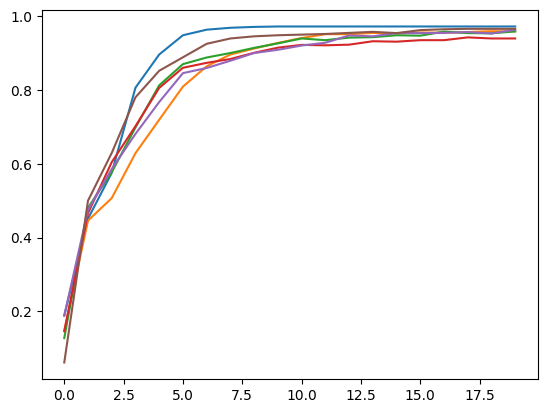

In [7]:
# Define the fractions
fractions = np.arange(0, 101, 20) / 100

# Initialize parameters for the model
ntokens = 8  # size of vocabulary
emsize = 10  # embedding dimension
nhead = 2  # number of heads in the nn.MultiheadAttention
d_hid = 10  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability
learning_rate = 1e-3
num_epochs = 2000

model_dir = "overlap transformers models"
os.makedirs(model_dir, exist_ok=True)

source, target = getTrainingData(songStrings, 2)

for fraction in fractions:

    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

    W=[]
    model.train()  # Set the model to training mode
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

    for epoch in range(num_epochs):
        total_loss = 0
        
        # Here, we assume batching is handled externally, and source is directly fed into the model
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        
        source_tensor = torch.tensor(input_list, dtype=torch.long)
        target_tensor = torch.tensor(output_list, dtype=torch.long)

        # Adjust for PyTorch expecting (sequence_length, batch_size), so we transpose source and target
        src = source_tensor.transpose(0, 1)  # Now shape [41, sentences]
        tgt = target_tensor.transpose(0, 1)  # Now shape [41, sentences]
        
        output = model(src)  # Forward pass: compute the output of the model
        
        # Output is [sequence_length, batch_size, ntokens], target is [sequence_length, batch_size]
        # Flatten output to [sequence_length*batch_size, ntokens] for compatibility with CrossEntropyLoss
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)  # Compute the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        total_loss += loss.item()
        
        avg_loss = total_loss / src.size(1)  # average loss per sentence

        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            
            W.append(test(model,source_tensor,target_tensor))

            print("acc:",W[-1])
        
        input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)

    plot(W)

    model_save_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')

    torch.save(model.state_dict(), model_save_path)
    
    print(f"Model saved at {model_save_path}")


In [9]:

fractions = np.arange(0, 101, 20) / 100

# Define a directory to save/load models
model_dir = "overlap transformers models"

# Assuming getTrainingData and split_and_shuffle_data_randomly_based_on_fraction are defined as before

# Load the song strings
songStrings = np.array([
     "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
     "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEABEF"
])

# Initialize the model parameters here (ntokens, emsize, etc.), same as during training
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

accuracies = np.zeros((len(fractions), len(songStrings))) 
 # For storing accuracies of each song at each fraction
for frac_idx, fraction in enumerate(fractions):

    for song_idx, song in enumerate(songStrings):
        
        source, target = getTrainingData(np.array([song]), 1)  # Get data for the current song

        # for frac_idx, fraction in enumerate(fractions):

        model_path = os.path.join(model_dir, f'model_at_fraction_{fraction:.2f}.pt')
        model.load_state_dict(torch.load(model_path))
        model.eval()  # Set the model to evaluation mode

        correct = 0
        total = 0

        # input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction)
        # source_tensor = torch.tensor(input_list, dtype=torch.long)
        # target_tensor = torch.tensor(output_list, dtype=torch.long)

        source_tensor = torch.tensor(source, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.long)

        with torch.no_grad():
            
            src = source_tensor.transpose(0, 1)
            tgt = target_tensor.transpose(0, 1)

            output = model(src)
            predictions = output.argmax(dim=2)

            correct += (predictions == tgt).sum().item()
            total += tgt.numel()

        accuracy = correct / total
        accuracies[frac_idx, song_idx] = accuracy  # Store accuracy for this song at this fraction

# Print or process the accuracies array as needed
for song_idx, song in enumerate(songStrings):
    print(f"Accuracies for song {song_idx}:")
    for frac_idx, fraction in enumerate(fractions):
        print(f"Fraction: {fraction}, Accuracy: {accuracies[frac_idx, song_idx]}")


Accuracies for song 0:
Fraction: 0.0, Accuracy: 0.8112659698025552
Fraction: 0.2, Accuracy: 0.9262485481997678
Fraction: 0.4, Accuracy: 0.9384436701509872
Fraction: 0.6, Accuracy: 0.9413472706155633
Fraction: 0.8, Accuracy: 0.9663182346109176
Fraction: 1.0, Accuracy: 0.9668989547038328
Accuracies for song 1:
Fraction: 0.0, Accuracy: 0.9727061556329849
Fraction: 0.2, Accuracy: 0.9663182346109176
Fraction: 0.4, Accuracy: 0.9715447154471545
Fraction: 0.6, Accuracy: 0.943089430894309
Fraction: 0.8, Accuracy: 0.929732868757259
Fraction: 1.0, Accuracy: 0.7375145180023229


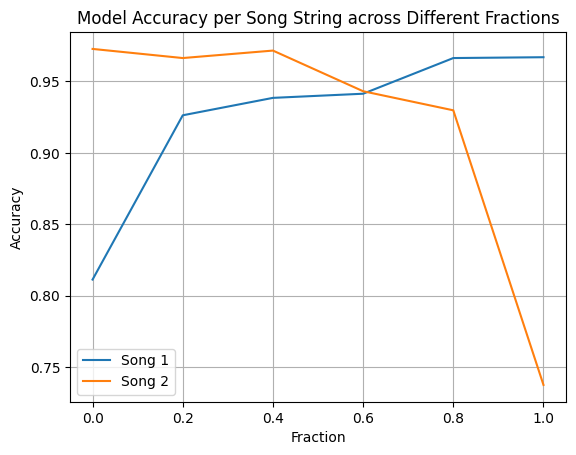

In [10]:
import matplotlib.pyplot as plt

# Plot accuracies for each song string
for song_idx, song in enumerate(songStrings):
    plt.plot(fractions, accuracies[:, song_idx], label=f'Song {song_idx+1}')

plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Song String across Different Fractions')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

def getTrainingData(songStrings, nrOfSongs):
    notes = list("ABCDEFGH")
    chord = [[0], [1], [2], [3], [4], [5], [6], [7]]
    source = []
    target = []
    for s in range(nrOfSongs):
        for i in range(42):
            sentence = []
            answer = []
            for j in range(41):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return np.array(source), np.array(target)

def split_and_shuffle_data_randomly_based_on_fraction(source, target, fraction):
    total_rows = source.shape[0] // 2
    first_set_rows = int(total_rows * fraction)
    second_set_rows = total_rows - first_set_rows

    first_set_indices = np.random.choice(range(total_rows), first_set_rows, replace=False)
    second_set_indices = np.random.choice(range(total_rows, 2 * total_rows), second_set_rows, replace=False)

    combined_indices = np.concatenate((first_set_indices, second_set_indices))
    np.random.shuffle(combined_indices)

    input_list = source[combined_indices]
    output_list = target[combined_indices]

    return input_list, output_list

# Data generation and preparation
songStrings = np.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEABEF"
])

source_mixed, target_mixed = getTrainingData(songStrings, 2)
fraction = 0.5
input_list, output_list = split_and_shuffle_data_randomly_based_on_fraction(source_mixed, target_mixed, fraction)

print(input_list.shape, output_list.shape)
